In [3]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

from keras.utils import to_categorical

from keras import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [4]:
# We define a specific seed so that results are repeatable:
from numpy.random import seed
from tensorflow.random import set_seed
seed(0)
set_seed(0)

# Creating a standard neural network
In this project, we will compare two methods of classifying music. Method 1 will involve a standard neural network (NN), where we preprocess the audio data to calculate numerical values of common features, and then use these values as input variables for our neural network classification algorithm. Method 2 will involve a convolutional neural network (CNN). We will input 3 variables taken from the 3D array image data of the audio in spectogram form. The first method uses more unique classes of features, while the second requires less preprocessing as it less features, but is more detailed in that it processes image data pixel-by-pixel. Let us train and test a model for each method and compare the results to see which is more efficient. in this notebook we discuss Method 1.

We begin by collecting our data into a useful format for input into our neural network. For increased precision we split each audio file into 3 second segments. We then found the mean and variance of the numerical values of each of the features detailed in our "Preprocessing" notebook for each 3 second audio clip. Then, we appended each set of data into a database contained in a csv file. This has already been done and we simply import the csv file below.

In [5]:
# Note to reader: Change the path variable to suit the location of the dataset file on your device.
path = 'C:/Users/Joshua/Documents/University/Year-3/Intro-to-AI/Data'

data = pd.read_csv(f'{path}/features_3_sec.csv')
data = data.iloc[0:, 1:] 
data.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [12]:
# We break down our database to define the input variables for our neural network.

# Input data x:
x = data.loc[:, data.columns != 'label']
# Desired output y:
y = data['label']

cols = x.columns
num_features = len(cols)
num_classes = len(np.unique(y))
print('There are ', num_features, ' input features and', num_classes, ' output classes.')

# Here we transform the variables to the optimal format.
# As we see below, y is currently an array containing the genre information for each data entry.
# We want to transform y to a 2D array with the same length as x, but with a width equal to the number of unique genres.
# We do this using the method below.

print("y variable pre-transform:")
print(y)

y = list(y)
y_pos1 = []

for i in y:
    index = y.index(i)
    y_pos1.append(index)
    
unique_vals = list(np.unique(y_pos1))

y_pos2 = []
        
for k in y_pos1:
    if k in unique_vals:
        index = unique_vals.index(k)
        y_pos2.append(index)

y = to_categorical(y_pos2)

print("y variable post-transform:")
print(y)

# Define the training and test split for our neural network:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

There are  58  input features and 10  output classes.
y variable pre-transform:
0       blues
1       blues
2       blues
3       blues
4       blues
        ...  
9985     rock
9986     rock
9987     rock
9988     rock
9989     rock
Name: label, Length: 9990, dtype: object
y variable post-transform:
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [7]:
# Normalise input data to have unit variance:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#Now define and train our model, using a sequential layer to access tensorflow through keras:
model = Sequential()

model.add(Dense(128, input_dim = num_features, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=500)

Epoch 1/500
219/219 [==============================] - 1s 1ms/step - loss: 2.1333 - accuracy: 0.2343
Epoch 2/500
219/219 [==============================] - 0s 1ms/step - loss: 1.5969 - accuracy: 0.4259
Epoch 3/500
219/219 [==============================] - 0s 1ms/step - loss: 1.3487 - accuracy: 0.5314
Epoch 4/500
219/219 [==============================] - 0s 1ms/step - loss: 1.1851 - accuracy: 0.5873
Epoch 5/500
219/219 [==============================] - 0s 1ms/step - loss: 1.1003 - accuracy: 0.6226
Epoch 6/500
219/219 [==============================] - 0s 1ms/step - loss: 1.0241 - accuracy: 0.6541
Epoch 7/500
219/219 [==============================] - 0s 1ms/step - loss: 0.9531 - accuracy: 0.6779
Epoch 8/500
219/219 [==============================] - 0s 1ms/step - loss: 0.9046 - accuracy: 0.6934
Epoch 9/500
219/219 [==============================] - 0s 1ms/step - loss: 0.8560 - accuracy: 0.7126
Epoch 10/500
219/219 [==============================] - 0s 1ms/step - loss: 0.8252 - accura

219/219 [==============================] - 0s 1ms/step - loss: 0.1426 - accuracy: 0.9700
Epoch 82/500
219/219 [==============================] - 0s 1ms/step - loss: 0.1445 - accuracy: 0.9705
Epoch 83/500
219/219 [==============================] - 0s 1ms/step - loss: 0.1384 - accuracy: 0.9715
Epoch 84/500
219/219 [==============================] - 0s 1ms/step - loss: 0.1268 - accuracy: 0.9769
Epoch 85/500
219/219 [==============================] - 0s 1ms/step - loss: 0.1288 - accuracy: 0.9739
Epoch 86/500
219/219 [==============================] - 0s 1ms/step - loss: 0.1300 - accuracy: 0.9745
Epoch 87/500
219/219 [==============================] - 0s 1ms/step - loss: 0.1242 - accuracy: 0.9757
Epoch 88/500
219/219 [==============================] - 0s 1ms/step - loss: 0.1263 - accuracy: 0.9750
Epoch 89/500
219/219 [==============================] - 0s 1ms/step - loss: 0.1180 - accuracy: 0.9794
Epoch 90/500
219/219 [==============================] - 0s 1ms/step - loss: 0.1184 - accuracy: 

219/219 [==============================] - 0s 1ms/step - loss: 0.0356 - accuracy: 0.9976
Epoch 161/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0378 - accuracy: 0.9960
Epoch 162/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0345 - accuracy: 0.9974
Epoch 163/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0338 - accuracy: 0.9978
Epoch 164/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0315 - accuracy: 0.9972
Epoch 165/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0321 - accuracy: 0.9983
Epoch 166/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0306 - accuracy: 0.9980
Epoch 167/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0315 - accuracy: 0.9982
Epoch 168/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0315 - accuracy: 0.9980
Epoch 169/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0308 - a

219/219 [==============================] - 0s 1ms/step - loss: 0.0150 - accuracy: 0.9989
Epoch 240/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0142 - accuracy: 0.9993
Epoch 241/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0139 - accuracy: 0.9990
Epoch 242/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0132 - accuracy: 0.9991
Epoch 243/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0140 - accuracy: 0.9991
Epoch 244/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0139 - accuracy: 0.9993
Epoch 245/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0131 - accuracy: 0.9994
Epoch 246/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0133 - accuracy: 0.9986
Epoch 247/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0126 - accuracy: 0.9992
Epoch 248/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0128 - a

219/219 [==============================] - 0s 1ms/step - loss: 0.0092 - accuracy: 0.9989
Epoch 319/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0096 - accuracy: 0.9988
Epoch 320/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0088 - accuracy: 0.9995
Epoch 321/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0085 - accuracy: 0.9991
Epoch 322/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0098 - accuracy: 0.9982
Epoch 323/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0087 - accuracy: 0.9992
Epoch 324/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0086 - accuracy: 0.9988
Epoch 325/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0087 - accuracy: 0.9984
Epoch 326/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0077 - accuracy: 0.9992
Epoch 327/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0082 - a

219/219 [==============================] - 0s 1ms/step - loss: 0.0068 - accuracy: 0.9988
Epoch 398/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0064 - accuracy: 0.9992
Epoch 399/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0065 - accuracy: 0.9988
Epoch 400/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0059 - accuracy: 0.9991
Epoch 401/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0060 - accuracy: 0.9992
Epoch 402/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0063 - accuracy: 0.9994
Epoch 403/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0067 - accuracy: 0.9982
Epoch 404/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0055 - accuracy: 0.9994
Epoch 405/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0066 - accuracy: 0.9989
Epoch 406/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0057 - a

Epoch 476/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 0.9988
Epoch 477/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 0.9993
Epoch 478/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 0.9982
Epoch 479/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0055 - accuracy: 0.9993
Epoch 480/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0053 - accuracy: 0.9987
Epoch 481/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 0.9992
Epoch 482/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 0.9994
Epoch 483/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0052 - accuracy: 0.9992
Epoch 484/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0047 - accuracy: 0.9993
Epoch 485/500
219/219 [==============================] - 0s 1ms/step - lo

In [8]:
# Now we will test the model:
loss, accuracy = model.evaluate(x_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

94/94 [==============================] - 0s 971us/step - loss: 0.6882 - accuracy: 0.8755
Loss: 0.6882120370864868
Accuracy: 0.8755422234535217


Text(0, 0.5, 'Loss')

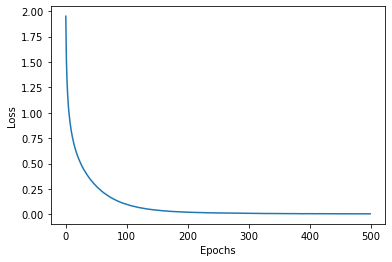

In [9]:
# Plot a graph of loss over time:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

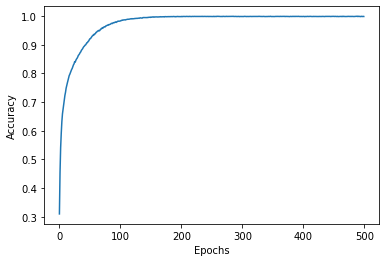

In [10]:
# Plot a graph of accuracy over time:
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Predicting genre weighting:

To make a model that predicts the probability weighting of an audio file we can use the method below. As our sample is taken from the csv file used to train the neural network it's weighted heavily to the relevant genre. The issue here is that in order to predict the genre of a new audio file, we would have to create a function that calculated the normalised mean and variance of each feature of the song, which is inefficient. CNNs are advantageous in this regard, because they only need the spectogram image file as input, which is easier to preprocess than defining a function to calculate all of our input variables.

In [11]:
sample = x[0:1]
print("Sample:")
print(sample)
prediction = model.predict(sample, batch_size = 1)
print("Prediction:")
print(prediction)

Sample:
   length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0   66149          0.335406         0.091048  0.130405  0.003521   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1773.065032          167541.630869              1972.744388   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_mean  mfcc16_var  \
0           117335.771563   3714.560359  ...    -2.853603   39.687145   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0     -3.24128   36.488243     0.722209   38.099152    -5.050335   33.618073   

   mfcc20_mean  mfcc20_var  
0    -0.243027   43.771767  

[1 rows x 58 columns]
Prediction:
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
